### ILWISPy for basic image processing

Notebook prepared by Ben Maathuis and Bas Retsios. ITC-University of Twente, Enschede. The Netherlands

Within this Notebook your are going to use ILWISPy in conjunction with a number of common used Python libraries, like Numpy and Matplotlib, which have already been introduced in the previous Notebook. 


As input, a Sentinel 2A image, retained in it's original SAFE format, containing only the spectral channels at 20 metres spatial resolution, is provided. The spectral channels will be directly retrieved from the zip file. The procedure will be identical if data would be downloaded by yourself from the Copernicus Open Access Hub (https://scihub.copernicus.eu/dhus).

A number of common used image processing routines will be demonstrated:
+ image retrieval and data exchange between ILWISPY / Numpy array 
+ image visualization of selected spectral bands and color composites
+ image statistics
+ creating subsets
+ filtering
+ calculation of indices
+ reprojecting and resampling
+ review of spectral signature- spectral reflectance curves and feature plots
+ image dimensionality reduction - principal component transform
+ unsupervised classification - clustering
+ supervised classification - using the box, minimum distance to mean, maximum likelihood, spectral angle and prior probability classifiers 


Before we start, first load the required libraries to run this Notebook. If there is a message after executing the cell below, ensure that you install, using the command from within your python folder 'python -m pip install ...*package*...', e.g. for numpy: 'python -m pip install numpy'.

Sample data available at: https://filetransfer.itc.nl/pub/52n/ilwis_py/sample_data/Intro_RS_ILWISPy.zip. Unzip the file. Here it is assumed that the data folder '/Intro_RS_ILWISPy' is situated within the notebook folder! It is furthermore assumed that you have locally installed ILWIS386 for data visualization when data is written to disk.

Prerequisite: You have reviewed the notebook 'Intro_ILWISPy.ipynb', available at: https://filetransfer.itc.nl/pub/52n/ilwis_py/notebooks/. Note that the files with postfix *_result.html* files show the processed results if the notebook would be executed.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import xml.etree.ElementTree as xml
import ilwis
import shutil

Set your working directory

In [ ]:
#use the Python function os.getcwd() to retrieve the current folder used and add a sub-folder
work_dir = os.getcwd() + '/Intro_RS_ILWISPy'

 #set the working directory for ILWISPy
ilwis.setWorkingCatalog(work_dir)
print(work_dir)

Note the ILWISPy version used

In [ ]:
ilwis.version()

### Import Sentinel 2A
Within this notebook you are going to look at a Sentinel Level 2A MSI satellite image from 20190925 over a portion the Gezira Irrigation Scheme, near Wad Medani, Sudan. The data is provided in the original SAFE format (https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/data-formats). The Sentinel-2 image file comes with many bands at different resolutions (10m, 20m and 60m). Not all bands are available in all resolutions in this sample data set, bands at 10 and 60 meters spatial resolution have been removed, to reduce the data volume. The file structure has not been modified!
#### Sentinel 2 MSI Band Details

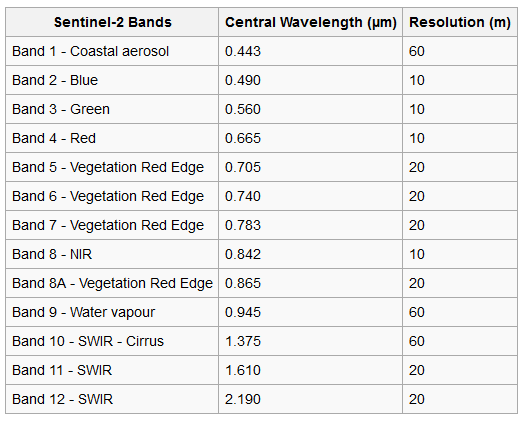

#### Extraction of spectral bands from a Sentinel-2 MSI image
The following code-cells will extract selected bands from the Sentinel-2, level 2A image file. In this exercise we have only provided bands B02, B03, B04, B05, B06, B07, B8A, B11, B12 and the Scene Classification (SCL) product, all at 20m resolution.

The filename of the Sentinel image must match the one in the next cell, without the .zip extension. Change the name if needed.

In [ ]:
S2_file = 'S2A_MSIL2A_20190925T080651_N0213_R078_T36PWA_20190925T123127'
sentinelfile = (S2_file)
band = sentinelfile.split('_')
band = band[5] + '_' + band[2]

# Create a list of the bands that we are interested in
bands = []
bands.append(band + '_B02_20m') # Blue
bands.append(band + '_B03_20m') # Green
bands.append(band + '_B04_20m') # Red
bands.append(band + '_B05_20m') # Vegetation Red Edge
bands.append(band + '_B06_20m') # Vegetation Red Edge
bands.append(band + '_B07_20m') # Vegetation Red Edge
bands.append(band + '_B8A_20m') # NIR - Vegetation Red Edge as B08 not available at 20 meters resolution
bands.append(band + '_B11_20m') # SWIR
bands.append(band + '_B12_20m') # SWIR
bands.append(band + '_SCL_20m') # Scene Classification Product

print(sentinelfile)

Open the Sentinel zipfile and extract some metadata. Note that it is not required to unzip the zipfile. Furthermore, in Python it is possible to process the file in memory.

In [ ]:
filename = work_dir + '/'+ sentinelfile + '.zip'
print('File location/name = ', filename)
z = ZipFile(filename)
msil = z.open(sentinelfile + '.SAFE/MTD_MSIL2A.xml') # open a sentinel-2 xml file that is inside the zipfile
msil = xml.parse(msil).getroot() # go through the xml file and extract the scale factor for the reflectance bands and their filenames
namespace_msil = msil.tag.split('}')[0] + '}'
scalefactor = float(msil.find(namespace_msil + "General_Info/Product_Image_Characteristics/QUANTIFICATION_VALUES_LIST/BOA_QUANTIFICATION_VALUE").text)
filenames = msil.findall(namespace_msil + 'General_Info/Product_Info/Product_Organisation/Granule_List/Granule/IMAGE_FILE')

print()
print ('Scaling factor to convert to Radiances = ',scalefactor)

Extract the selected bands from the Sentinel-2 data file. The spectral channels / bands in the datasets are imported using the ilwis.RasterCoverage() routine, check also the inline comments in the cell below.

In [ ]:
rastercoverages = []

for band in bands:
    for name in filenames:
        name = name.text + '.jp2'
        if band in name:
            print(name)
            z.extract(sentinelfile + '.SAFE/' + name, work_dir) # extracted from zip file
            shortfilename = work_dir + '/' + name.split('/')[-1] # create local file name in work_dir
            #print(shortfilename)
            if os.path.isfile(shortfilename): 
                os.unlink(shortfilename) # delete file if exists
            shutil.move(work_dir + '/' + sentinelfile + '.SAFE/' + name, work_dir) # move files from initial folder to work_dir
            rc = ilwis.RasterCoverage(name.split('/')[-1]) # open in ILWIS
            rastercoverages.append(rc) # retrieve all rastercoverages
shutil.rmtree(work_dir + '/' + sentinelfile + '.SAFE/') # remove folder created by unzip routine

### Quick visualization of the imported data set
Here only the spectral channels are retrieved, not the scene classifier image. This layer will be used later. Data is imported using the function ILWIS Pixel-iterator funtion 'iter(rastercoverages)', which is called repeatedly by Python 'np.fromiter(iterator, datatype, length)', re-shaped  to 2-D and transformed into a 3-D Numpy array. Check the inline comments in the cell below.

In [ ]:
multiRc2Np = []  # create empty array
for i in range(0, len(rastercoverages) - 1): # skip last layer, here the SCL image
    rc2Np = np.fromiter(iter(rastercoverages[i]), np.uint, rastercoverages[i].size().linearSize()) #extract pixel data for all layers (1-D)
    rc2Np = rc2Np.reshape((rastercoverages[i].size().ysize, rastercoverages[i].size().xsize)) # reshape to 2-D
    multiRc2Np.append(rc2Np) # append all data to array
multiRc2Np = np.array(multiRc2Np) # create 3 D-array
print(np.shape(multiRc2Np))

In [ ]:
# Display some of the image layers using matplotlib imshow()
%matplotlib inline 

fig, ax = plt.subplots(2, 2, figsize=(17, 17))

ax[0,0].imshow(multiRc2Np[0], vmin=50, vmax=1200, cmap='Greys_r')
ax[0,0].set_title('BLUE')

ax[0,1].imshow(multiRc2Np[1], vmin=450, vmax=1800, cmap='Greys_r')
ax[0,1].set_title('GREEN')

ax[1,0].imshow(multiRc2Np[2], vmin=300, vmax=2400, cmap='Greys_r')
ax[1,0].set_title('RED')

ax[1,1].imshow(multiRc2Np[6], vmin=1000, vmax=4800, cmap='Greys_r')
ax[1,1].set_title('NIR')

Now let's use the data as an ilwis raster coverage image stack

In [ ]:
# envelope =  min X, max Y, max X, min Y,  here 499980 1600020 609780 1490220 (metric units - meters)
# gridsize =  no columns, no rows
# note name of georeference - here the name of output file created further below is used

grf = ilwis.GeoReference('code=georef:type=corners, csy=epsg:29636, envelope=499980 1600020 609780 1490220, gridsize=5490 5490, cornerofcorners=yes, name=gezira')
dfNum = ilwis.DataDefinition(ilwis.NumericDomain('code=value'), ilwis.NumericRange(0, 10000, 1)) 
rcNew = ilwis.RasterCoverage()
rcNew.setSize(ilwis.Size(5490, 5490,9))
rcNew.setGeoReference(grf)
rcNew.setDataDef(dfNum)

In [ ]:
rcNew.array2raster(multiRc2Np) 

In [ ]:
print(rcNew.size())

If you want to visualize the imported data using ILWIS 386, uncomment the line in the cell below and execute the cell. Open ILWIS 386, navigate to the data folder and display the maplist created as a color composite. Note that for appropriate visualization the data needs to be stretched, see also the 'vmin' and 'vmax' above.

In [ ]:
#rcNew.store('s2.mpl')

#### Image enhancement
In the cells below we will show you how to conduct a linear contract stretch as well as some basic filtering operations. First we will inspect the metadata required to conduct an operation, here 'selection' is used as an example.

In [ ]:
print(ilwis.operationMetaData('selection'))
print(ilwis.operationMetaData('selection', 'inparameters')) # how many input parameters needed
print(ilwis.operationMetaData('selection', 'outparameters')) # how many output parameters 
print(ilwis.operationMetaData('selection', 'input',1,'name'))
print(ilwis.operationMetaData('selection', 'input',2,'name'))
print(ilwis.operationMetaData('selection','output',1,'name')) 

In [ ]:
# select some spectral channels from the initial image stack, here band 0 - Blue
# note numbering starts from 0
Blue = ilwis.do('selection',rcNew,"rasterbands(0)")
print(Blue.size().xsize)
print(Blue.size().ysize)
print(Blue.size().zsize)

In the cell below a 'definition' is created, as retrieval of image statistics is required very often when new images are processed. The definition is executed in the cell further below.

In [ ]:
def descriptive_statistics(raster_input):
    print('Raster size: ',raster_input.size())
    print()
    print('Map extent: ',raster_input.envelope())
    print()
    coordSys_input = raster_input.coordinateSystem()
    print('Coordinate system: ',coordSys_input.toWKT())
    print()
    print('Proj4: ',coordSys_input.toProj4())
    print()
    datadef_input = raster_input.datadef()
    print('Data type: ', datadef_input.domain())
    stats_input = raster_input.statistics(ilwis.PropertySets.pHISTOGRAM)
    print()
    print('Minimum: ',stats_input[ilwis.PropertySets.pMIN]) 
    print('Maximum: ',stats_input[ilwis.PropertySets.pMAX]) 
    print('Mean: ',stats_input[ilwis.PropertySets.pMEAN]) 
    print('No pixels - also nodata: ',stats_input[ilwis.PropertySets.pCOUNT]) 
    print('No pixels - no nodata: ',stats_input[ilwis.PropertySets.pNETTOCOUNT]) 
    print('Sum all: ',stats_input[ilwis.PropertySets.pSUM]) 

    print()
    x=[a for (a,b) in stats_input.histogram()][:-1] 
    y=[b for (a,b) in stats_input.histogram()][:-1]

    plt.plot(x,y,label='Raster Map values')
    plt.xlabel('Data Range')
    plt.ylabel('Data Frequency')
    plt.title('Raster Histogram')
    plt.legend()

In [ ]:
#execute the definition using the selected spectral channel
descriptive_statistics(Blue)

As noted from the metadata description of 'selection' it can be applied for multiple purposes, now 'selection' is used to clip / extract a portion of the image to focus on our area of interest.

In [ ]:
# sub map creation
rcSelect = ilwis.do('selection',rcNew,"boundingbox(740 5, 3339 1754)")
print(rcSelect.size().xsize)
print(rcSelect.size().ysize)
print(rcSelect.size().zsize)

For the selected ILWIS raster bands apply a linear stretch using a cut-off thresholds at 0.5 % lower and upper limit, then convert to byte, using a precision of 1, this is followed by a conversion to a numpy array, so it can be visualized using the matplotlib function imshow(). 

In [ ]:
#Blue - note the rasterband selected

b1 = ilwis.do('selection',rcSelect,"rasterbands(0)")
b1s = ilwis.do('linearstretch',b1, 0.5)
b1s = ilwis.do('setvaluerange', b1s, 0, 255, 1)

b1_2np = np.fromiter(iter(b1s), np.ubyte, b1s.size().linearSize()) 
b1_2np = b1_2np.reshape((b1s.size().ysize, b1s.size().xsize))

In [ ]:
#Green - note the rasterband selected

b2 = ilwis.do('selection',rcSelect,"rasterbands(1)")
b2s = ilwis.do('linearstretch',b2, 0.5)
b2s = ilwis.do('setvaluerange', b2s, 0, 255, 1)

b2_2np = np.fromiter(iter(b2s), np.ubyte, b2s.size().linearSize()) 
b2_2np = b2_2np.reshape((b2s.size().ysize, b2s.size().xsize))

In [ ]:
#Red - note the rasterband selected

b3 = ilwis.do('selection',rcSelect,"rasterbands(2)")
b3s = ilwis.do('linearstretch',b3, 0.5)
b3s = ilwis.do('setvaluerange', b3s, 0, 255, 1)

b3_2np = np.fromiter(iter(b3s), np.ubyte, b3s.size().linearSize()) 
b3_2np = b3_2np.reshape((b3s.size().ysize, b3s.size().xsize))

In [ ]:
#NIR - note the rasterband selected

b4 = ilwis.do('selection',rcSelect,"rasterbands(6)")
b4s = ilwis.do('linearstretch',b4, 0.5)
b4s = ilwis.do('setvaluerange', b4s, 0, 255, 1)

b4_2np = np.fromiter(iter(b4s), np.ubyte, b4s.size().linearSize()) 
b4_2np = b4_2np.reshape((b4s.size().ysize, b4s.size().xsize))

Once the spectral bands are processed and converted to a Numpy array, we can create band combinations, allowing us to display the data as a color composite. Below two composites are created: a natural and false color composite. Review the MSI spectral channel table and note the spectral regions covered by each of these spectral bands and how they are combined to create the composite.

In [ ]:
# create true color composite (in RGB)
nc = np.dstack((b3_2np, b2_2np, b1_2np))

# create false color composite (in RGB)
fc = np.dstack((b4_2np, b3_2np, b1_2np))

In [ ]:
#create a plot
%matplotlib inline 
fig1 = plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(nc)
plt.title('nc')
plt.subplot(1, 2, 2)
plt.imshow(fc)
plt.title('fc')

The option '%matplotlib notebook' allows some interaction, e.g. zooming, panning and in the lower right hand corner also the row/column location and map value is given. Check the colour composite image into more detail as well as the image values. This might not work using Linux. Uncomment the line below to run the code under Windows

In [ ]:
#inspect image more closely, using the zoom and pan function, here the fc is used, you can change it to nc
#note: might not work when using linux

%matplotlib notebook  
fig2 = plt.figure(figsize=(12, 8))
plt.imshow(fc)
plt.title('fc')

Above example shows the selection of individual bands, multiple bands can be selected as well and processing can be conducted on all selected layers using single statements. Code cell below is providing the same output but now in ILWIS format

In [ ]:
multiple_bands = []
multiple_bands = ilwis.do('selection',rcSelect,"rasterbands(0..9)") # for specific bands use band number as "rasterbands(0,1,2,6)"
step1 = ilwis.do('linearstretch',multiple_bands, 1)
mb_stretch = ilwis.do('setvaluerange', step1, 0, 255, 1)

print(multiple_bands.size()) #check extracted dimensions 

Eventually write your results to disk and these can be visualized using ILWIS 386. To do this uncomment and execute the cell below.

In [ ]:
#mb_stretch.store('mb_stretch.mpl') # write color composite in ILWIS format on disk

Another common used image processing routine is filtering. Let's have a look at some filter routines.

In [ ]:
print(ilwis.operationMetaData('linearrasterfilter'))
print(ilwis.operationMetaData('linearrasterfilter', 'description'))
print(ilwis.operationMetaData('linearrasterfilter', 'keyword'))
print()
print(ilwis.operationMetaData('linearrasterfilter', 'input',1,'name'))
print(ilwis.operationMetaData('linearrasterfilter', 'input',2,'name'))
print(ilwis.operationMetaData('linearrasterfilter','output',1,'name')) 

Let's write the output to disk, use ILWIS 386 to check the data, e.g. display the output created using a 'Gray' Representation. Display the output of the filters created on top of each other and switch the top layer on and off to note the differences, display the output images using a 'Gray' Representation.

In [ ]:
#detects linear features in an image
filter_edge = ilwis.do('linearrasterfilter', b4s, 'edgeenhancement')
filter_edges = ilwis.do('linearstretch',filter_edge, 1)
filter_edges = ilwis.do('setvaluerange', filter_edge, 0, 255, 1)
filter_edges.store('b4_edge.mpr')

In [ ]:
#standard average or smooth filter 
filter_avg = ilwis.do('linearrasterfilter', b4s, 'average')
filter_avg = ilwis.do('setvaluerange', filter_avg, 0, 255, 1)
filter_avg.store('b4_avg.mpr')

In [ ]:
#edges enhancement
filter_lap = ilwis.do('linearrasterfilter', b4s, 'laplace3x3')
filter_laps = ilwis.do('linearstretch',filter_lap, 1)
filter_laps = ilwis.do('setvaluerange', filter_laps, 0, 255, 1)
filter_laps.store('b4_lap.mpr')

#### Vegetation and soils indices
Now let's create some common used indices

#### Normalized Difference Vegetation Index (NDVI)
```
NDVI = ((NIR - Red)/(NIR + Red))
```

* NIR = pixel values from the near-infrared band
* Red = pixel values from the red band

In [ ]:
# select required spectral channels from the initial image stack, here the visible red and NIR channels
Nir_in = ilwis.do('selection',rcSelect,"rasterbands(6)")
Red_in = ilwis.do('selection',rcSelect,"rasterbands(2)")

# Apply Sentinel-2 scaling factor to convert to radiance
Nir_cor = ilwis.do('mapcalc','(@1/10000)',Nir_in)
Red_cor = ilwis.do('mapcalc','(@1/10000)',Red_in)

ndvi = ilwis.do('mapcalc','(@1 - @2)/(@1 + @2)', Nir_cor, Red_cor)
ndvi = ilwis.do('setvaluerange', ndvi, -1, 1, 0.001)

In [ ]:
#review result for a specific pixel
l = 857
c = 1174

# for a given band already loaded as a variable, here Red and Nir
v_red = (Red_in.pix2value(ilwis.Pixel(c,l)))
print('original Red value:', v_red)

v_nir = (Nir_in.pix2value(ilwis.Pixel(c,l)))
print('original NIR value:',v_nir)

v_ndvi = (ndvi.pix2value(ilwis.Pixel(c,l)))
print('derived NDVI value:' ,v_ndvi)

check_ndvi = (v_nir-v_red)/(v_nir+v_red)
print('manual check NDVI value:' ,check_ndvi)

Let's write the output to disk, use ILWIS 386 to check the data, e.g. display the output created, inspect the histogram and check the data range and precision as given below

In [ ]:
dd = ndvi.datadef()
r = dd.range()
print(r)
ndvi.store('ndvi.mpr')

#### Soil-Adjusted Vegetation Index (SAVI) 

```
SAVI = ((NIR - Red) / (NIR + Red + L)) x (1 + L)
```
* NIR = pixel values from the near infrared band
* Red = pixel values from the near red band
* L = amount of green vegetation cover

In [ ]:
L = 0.5

savi = ilwis.do('mapcalc','((@1 - @2)/(@1 + @2 + @3)) * (1 + @3)', Nir_cor, Red_cor, L)
savi = ilwis.do('setvaluerange', savi, -1, 1, 0.001)
savi.store('savi.mpr')

#### Modified Normalized Difference Water Index (MNDWI) 
From the sample data set the SWIR band (check band 11 or 12 from the table above) selected in the cell below corresponds to Band 12! You can change it to band 11
```
MNDWI = (Green - SWIR) / (Green + SWIR)
```
* Green = pixel values from the green band
* SWIR = pixel values from the short-wave infrared band

In [ ]:
#SWIR band select here is raster layer 8 

Green_in = ilwis.do('selection',rcSelect,'rasterbands(1)')
SWIR_in = ilwis.do('selection',rcSelect,'rasterbands(8)')

#apply Sentinel-2 scaling factor to convert to radiance
Green_cor = ilwis.do('mapcalc','(@1/10000)', Green_in)
SWIR_cor = ilwis.do('mapcalc','(@1/10000)', SWIR_in)

mndwi = ilwis.do('mapcalc','((@1 - @2)/(@1 + @2))', Green_cor, SWIR_cor)
mndwi = ilwis.do('setvaluerange', mndwi, -1, 1, 0.001)
mndwi.store('mndwi.mpr')

#### Sentinel 2A SCL
Having obtained some idea on the land cover it is time to inspect the Scene Classified Image. In the cell below only the last layer (9) is extracted, transformed into a numpy array and displayed using imshow. 

In [ ]:
Scl2Np = []  # create empty array
for i in range(9, len(rastercoverages)): 
    Scl2Np = np.fromiter(iter(rastercoverages[i]), np.uint, rastercoverages[i].size().linearSize()) #extract pixel data for all layers (1-D)
    Scl2Np = Scl2Np.reshape((rastercoverages[i].size().ysize, rastercoverages[i].size().xsize)) # reshape to 2-D
Scl2Np = np.array(Scl2Np) # now a 2 D-array
print(np.shape(Scl2Np))

In [ ]:
#create empty raster 
rcScl = ilwis.RasterCoverage()
rcScl.setSize(ilwis.Size(5490, 5490,1))
rcScl.setGeoReference(grf)
rcScl.setDataDef(dfNum)

In [ ]:
rcScl.array2raster(Scl2Np) 
print(rcScl.size())
# sub map creation
rcScl_sub = ilwis.do('selection',rcScl,"boundingbox(740 5, 3339 1754)")
print(rcScl_sub.size())
rcScl_sub = ilwis.do('setvaluerange', rcScl_sub, 0, 12, 1)
#rcScl_sub.store('scl_sub.mpr') #uncomment if you want to store the image on disk

In [ ]:
#execute the statistics definition using the selected spectral channel
descriptive_statistics(rcScl_sub)

Sentinel L2A_Scene_Classification_ID (SCL product) uses the following coding system:
+ 0 = sc_nodata 
+ 1 = sc_saturated_defective 
+ 2 = sc_dark_feature_shadow 
+ 3 =  sc_cloud_shadow 
+ 4 = sc_vegetation 
+ 5 = sc_not_vegetated 
+ 6 = sc_water 
+ 7 = sc_unclassified 
+ 8 = sc_cloud_medium_proba 
+ 9 = sc_cloud_high_proba 
+ 10 = sc_thin_cirrus 
+ 11 = sc_snow_ice 

In [ ]:
#Retrieve mimimum and maximum map values
scl_stats = rcScl_sub.statistics(ilwis.PropertySets.pHISTOGRAM)
scl_min = scl_stats[ilwis.PropertySets.pMIN]
scl_max = scl_stats[ilwis.PropertySets.pMAX]
print(scl_min)
print(scl_max)

Inspect the Scl layer

In [ ]:
# Display some of the image layers using matplotlib imshow()
rcScl_sub_2np = np.fromiter(iter(rcScl_sub), np.int32, rcScl_sub.size().linearSize()) 
rcScl_sub_2np = rcScl_sub_2np.reshape((rcScl_sub.size().ysize, rcScl_sub.size().xsize))
%matplotlib inline
fig3 = plt.figure(figsize=(10, 7))
N = 1+(scl_max - scl_min)
cmap = plt.get_cmap('jet', N)
plt.imshow(rcScl_sub_2np, vmin=scl_min, vmax=scl_max, cmap=cmap)
plt.title('Scene Classfied Image')
plt.colorbar(fraction=0.025)

#### Reprojection and Resampling of the data
The input data might not be in the required projection and therefore requires resampling. Transform from UTM, here zone 36, to Lat-Lon. For a full listing of EPSG codes see: https://spatialreference.org/

In [ ]:
#transform from UTM projection, here zone 36 -'EPSG:32636' to lat-lon coordinates
#create target georeference
grfTarget = ilwis.GeoReference('code=georef:type=corners, csy=epsg:4326, envelope=33.136861 14.473261 33.619741 14.155836, gridsize=2600 1750, cornerofcorners=yes, name=Scl_resLL')


Conduct the actual resampling

In [ ]:
#conduct the resampling operation
rcScl_sub_res = ilwis.do('resample', rcScl_sub, grfTarget,'nearestneighbour')
print()
print(rcScl_sub_res.size())
print(rcScl_sub_res.coordinateSystem())
print(rcScl_sub_res.coord2value(ilwis.Coordinate(33.35, 14.35))) # E - N querying a location in lon/lat instead of UTM.

In [ ]:
#store the resampled data set - coordinate system assigned is now in lat-lon
rcScl_sub_res.store('Scl_resLL.mpr')

#### Check spectral signature and create a feature space plot

In [ ]:
rcSelect_rad = ilwis.do('mapcalc','@1/10000', rcSelect)

In [ ]:
#get info on specific pixel but now for all spectral channels, for multiple cover types

# here cover is bare
l = 557
c = 2157

bare = []
for n in range(0,(rcSelect_rad.size().zsize)):
    cllist = (rcSelect_rad.pix2value(ilwis.Pixel(c,l,n)))
    bare.append(cllist)

print("Values extracted for land cover 'bare':", bare)


# here cover is swamp
l = 863
c = 1634

swamp = []
for n in range(0,(rcSelect_rad.size().zsize)):
    cllist = (rcSelect_rad.pix2value(ilwis.Pixel(c,l,n)))
    swamp.append(cllist)

print("Values extracted for land cover 'swamp':", swamp)

# here cover is crop
l = 991
c = 2205

crop = []
for n in range(0,(rcSelect_rad.size().zsize)):
    cllist = (rcSelect_rad.pix2value(ilwis.Pixel(c,l,n)))
    crop.append(cllist)

print("Values extracted for land cover 'crops':", crop)

# here cover is water

l = 337
c = 2110

water = []
for n in range(0,(rcSelect_rad.size().zsize)):
    cllist = (rcSelect_rad.pix2value(ilwis.Pixel(c,l,n)))
    water.append(cllist)

print("Values extracted for land cover 'water':", water)

In [ ]:
# create a simple plot showing the differences in spectral reflectance of the selected channels of Sentinel-2 MSI 
%matplotlib inline
plt.figure(figsize=(12,7))
plt.plot(water, label='water')
plt.plot(bare, label='bare')
plt.plot(swamp, label='swamp')
plt.plot(crop, label='crops')

plt.ylim([0.0, 0.5])
plt.xlabel('S2 MSI Spectral Channels loaded')
plt.ylabel('Radiance')
plt.title('Spectral Reflectance Curves')
plt.legend()

#### Example feature space
Below a feature space is plotted for different band combinations using the values for the points extracted above. 

In [ ]:
import matplotlib.patches as mpatches
# only 4 spectral channels, respective classes are bare, swamp, crops and water

#input values as given for the cells above
b2_val = [0.0803, 0.0602,0.0096, 0.0596] # Blue
b3_val = [0.1356, 0.1599, 0.051, 0.1104] # Green
b4_val = [0.186, 0.0787, 0.0308, 0.158] # Red
b8_val = [0.2631,  0.4319, 0.4051, 0.0988] #NIR

color = ['red', 'orange', 'green', 'blue']

%matplotlib inline
plt.figure(figsize=(12,7))

plt.subplot(1, 2, 1)
plt.scatter(b2_val,b3_val, c = color, label = color)
plt.title('Scatter Plot')
plt.xlabel('B2')
plt.ylabel('B3')
plt.xlim([0, 0.3])
plt.ylim([0, 0.5])
plt.title('Feature Space Plot B2 and B3')
col_patch1 = mpatches.Patch(color='red', label='Bare')
col_patch2= mpatches.Patch(color='blue', label='Water')
col_patch3= mpatches.Patch(color='orange', label='Swamp')
col_patch4= mpatches.Patch(color='green', label='Crops')
plt.legend(handles=[col_patch1, col_patch2, col_patch3, col_patch4])


plt.subplot(1, 2, 2)
plt.scatter(b2_val,b8_val, c = color, label = color)
plt.title('Scatter Plot')
plt.xlabel('B2')
plt.ylabel('B8')
plt.xlim([0, 0.3])
plt.ylim([0, 0.5])
plt.title('Feature Space Plot B2 and B8')
col_patch1 = mpatches.Patch(color='red', label='Bare')
col_patch2= mpatches.Patch(color='blue', label='Water')
col_patch3= mpatches.Patch(color='orange', label='Swamp')
col_patch4= mpatches.Patch(color='green', label='Crops')
plt.legend(handles=[col_patch1, col_patch2, col_patch3, col_patch4])

plt.subplots_adjust(wspace=0.2)

#### Preparing some of the processed results based on the sample data provided
Next to the spectral channels below also the indices calculated are going to be included in the final data set that is going to be used for some additonal image processing. The combined data set created is a 3-D Numpy array which is transformed into an ILWIS map list and used as input for the classification procedure.

In [ ]:
rcndvi = np.fromiter(iter(ndvi), np.float64, b1s.size().linearSize()) 
rcndvi = rcndvi.reshape((b1s.size().zsize, b1s.size().ysize, b1s.size().xsize))
rcndvi.shape

In [ ]:
rcsavi = np.fromiter(iter(savi), np.float64, b1s.size().linearSize()) 
rcsavi = rcsavi.reshape((b1s.size().zsize, b1s.size().ysize, b1s.size().xsize))
rcsavi.shape

In [ ]:
rcmndwi = np.fromiter(iter(mndwi), np.float64, b1s.size().linearSize()) 
rcmndwi = rcsavi.reshape((b1s.size().zsize, b1s.size().ysize, b1s.size().xsize))
rcmndwi.shape

In [ ]:
print(rcSelect.size().xsize)
print(rcSelect.size().ysize)
print(rcSelect.size().zsize)

rcsat = np.fromiter(iter(rcSelect), np.int32, rcSelect.size().linearSize()) 
rcsat = rcsat.reshape((rcSelect.size().zsize, rcSelect.size().ysize, rcSelect.size().xsize))
rcsat.shape

Combine all numpy arrays into a numpy 3-D stack

In [ ]:
rcAll = np.array([rcsat[0], rcsat[1], rcsat[2], rcsat[3], rcsat[4], rcsat[5], rcsat[6], rcsat[7], rcsat[8], rcndvi[0], rcsavi[0], rcmndwi[0]])
rcAll.shape

Import the above created numpy image stack in ILWISPy

In [ ]:
#create empty raster 
rcAll_ilw = ilwis.RasterCoverage()
dfNumrc = ilwis.DataDefinition(ilwis.NumericDomain('code=value'), ilwis.NumericRange(-5, 10000, 0))
rcAll_ilw.setDataDef(dfNumrc)
rcAll_ilw.setSize(ilwis.Size(2600, 1750, 12))
rcAll_ilw.setGeoReference(rcSelect.geoReference())

In [ ]:
rcAll_ilw.array2raster(rcAll) 
print(rcAll_ilw.size())

#### Unsupervised classification

Clustering or unsupervised classification is the process of grouping or aggregating the pixel values of an image into a certain number of natural classes (groups) based on statistical similarity. 

In [ ]:
cluster_bands = []
cluster_bands = ilwis.do('selection',rcSelect,"rasterbands(0,1,2,6)")

In [ ]:
print(ilwis.operationMetaData('clusterraster'))
print()
print(ilwis.operationMetaData('clusterraster', 'description'))

In [ ]:
cluster_cl = ilwis.do('clusterraster',cluster_bands,'9')
cluster_cl.store('cluster_cl.mpr')

Inspect the resulting map using ILWIS 386, the main issue will be how the given an appropriate name to each of the clusters. Eventually change the number of clusters and run the clustering operation again

#### Supervised Classification 

As an example of a supervised classification the Box classifier is used below. For the area of interest a field survey was conducted at approximately the same time as the image was acquired.
The following classes are used:
+ 1: mainly bare
+ 2: swamp - depression with open vegatation cover
+ 3: swamp - covered with dense vegetation
+ 4: urban and infrastructure - including bare areas, e.g. between the houses / dirt roads
+ 5: river - like Blue Nile
+ 6: Open water - ponds and some temporary inundated areas related to irrigation scheduling
+ 7, 8, 9: different agricultural crops. Main crops grown during this season (summer season - mainly rainfed) are cotton, groundnut and sorghum

The field survey was used to prepare a map providing the training data required for supervised classification. This map is using the land cover labels as indicated above, note that the background area has been assigned to '0' 

In [ ]:
# Read the training sample map
roi_ds = ilwis.RasterCoverage('samples.mpr')
roi_dsin = np.fromiter(iter(roi_ds), np.ubyte, roi_ds.size().linearSize()) 
roi_dsin = roi_dsin.reshape((roi_ds.size().ysize, roi_ds.size().xsize))

In [ ]:
print(roi_dsin.shape)

In [ ]:
%matplotlib inline
fig5 = plt.figure(figsize=(10, 7))
cmap = plt.get_cmap('jet', 10)
plt.imshow(roi_dsin, vmin=0, vmax=9, cmap=cmap)
plt.title('Training Data')

cb = plt.colorbar(shrink=0.65)
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb.set_ticks(loc)
cb.set_ticklabels(labels)

#### Image classification
Retrieve information of the classification operation

In [ ]:
print(ilwis.operationMetaData('classification'))

Provide additional information on the parameters required

In [ ]:
print(ilwis.operationMetaData('classification', 'description'))
print(ilwis.operationMetaData('classification', 'inparameters')) # how many parameters needed
print(ilwis.operationMetaData('classification', 'outparameters')) # how many output values
print(ilwis.operationMetaData('classification', 'keyword'))
print()
print(ilwis.operationMetaData('classification','input',1,'name')) # first input parameter
print(ilwis.operationMetaData('classification','input',1,'description'))
print(ilwis.operationMetaData('classification','input',1,'type'))
print()
print(ilwis.operationMetaData('classification','input',2,'name')) # second input parameter
print(ilwis.operationMetaData('classification','input',2,'description'))
print(ilwis.operationMetaData('classification','input',2,'type'))
print()
print(ilwis.operationMetaData('classification','input',3,'name')) # third input parameter
print(ilwis.operationMetaData('classification','input',3,'description'))
print(ilwis.operationMetaData('classification','input',3,'type'))
print()
print(ilwis.operationMetaData('classification','input',4,'name')) # fourth input parameter
print(ilwis.operationMetaData('classification','input',4,'description'))
print(ilwis.operationMetaData('classification','input',4,'type'))
print()
print(ilwis.operationMetaData('classification','output',1,'name')) # output parameter
print(ilwis.operationMetaData('classification','output',1,'description'))
print(ilwis.operationMetaData('classification','output',1,'type'))

Remove the 0 value (assigned as background) from sample map and assign it to 'no data', note that in the equation below the '?' represents 'no data'

In [ ]:
sample_mod = ilwis.do('mapcalc','iff(@1>0,@1,?)',roi_ds)

Note the map list and sample set dimensions

In [ ]:
print(rcAll_ilw.size())
print(sample_mod.size())

Note the differences in values of the input map list data stack for the first 9 layers and the remaining 3 layers. 

In [ ]:
# pixel selected here by row and column 
l = 557
c = 2157

select = []
for n in range(0,(rcAll_ilw.size().zsize)):
    cllist = (rcAll_ilw.pix2value(ilwis.Pixel(c,l,n)))
    select.append(cllist)

print("Values extracted for selected pixel 'select':", select)

Perform the box classification, note the value used for the 'widen factor' - here 1 * STD of sample

In [ ]:
box_cl1 = ilwis.do('classification', 'box', rcAll_ilw, sample_mod, 1) 
box_cl1 = ilwis.do('setvaluerange', box_cl1, 0, 10, 1)
box_cl1.store('box_cl1.mpr')

Perform the box classification, note the value used for the 'widen factor' - here 2 * STD of sample

In [ ]:
box_cl2 = ilwis.do('classification', 'box', rcAll_ilw, sample_mod, 2) # STD * 2 of samples mean
box_cl2 = ilwis.do('setvaluerange', box_cl2, 0, 10, 1)
box_cl2.store('box_cl2.mpr')

Perform the box classification, note the value used for the 'widen factor' - here 3 * STD of sample

In [ ]:
box_cl3 = ilwis.do('classification', 'box', rcAll_ilw, sample_mod, 3) # STD * 3 of samples mean
box_cl2 = ilwis.do('setvaluerange', box_cl3, 0, 10, 1)
box_cl3.store('box_cl3.mpr')

Perform the minimum distance to mean (mindist) classification, note the value used for the 'threshold-distance' applied - here 1000. Note that here we use the initial raster data stack, without the 3 index maps! Why?

In [ ]:
mdist_cl1000 = ilwis.do('classification', 'mindist', rcSelect, sample_mod, 1000) # note minimum distance -check the map units, here int 16
mdist_cl1000 = ilwis.do('setvaluerange', mdist_cl1000, 0, 10, 1)
mdist_cl1000.store('mdist_cl1000.mpr')

Perform the minimum distance to mean according to the Minimum Mahalanobis distance (minmahadist). For each feature vector, the Mahalanobis distances towards class means are calculated. This includes the calculation of the variance-covariance matrix V for each class

In [ ]:
mmahdist_cl1000 = ilwis.do('classification', 'minmahadist', rcSelect, sample_mod, 1000) # note minimum distance -check the map units, here int 16
mmahdist_cl1000 = ilwis.do('setvaluerange', mmahdist_cl1000, 0, 10, 1)
mmahdist_cl1000.store('mmahdist_cl1000.mpr')

Other classifiers are the maximum likelihood, spectral angle and prior probalility classifiers (maxlikelihood, spectralangle, priorprob). The code fields below demonstrate, using the same sample set, how to implement these classification routines. You can check your results using ILWIS386, eventually adapt some of the parameters like the threshold or prior probalilities assigned and note their impact

In [ ]:
#maximum likelihood classifier, threshold distance used is 100
maxlik_cl = ilwis.do('classification', 'maxlikelihood', rcSelect, sample_mod, 100) 
maxlik_cl = ilwis.do('setvaluerange', maxlik_cl, 0, 10, 1)
maxlik_cl.store('maxlik_cl.mpr')

In [ ]:
#spectral angle classifier, threshold distance used is 100
specangle_cl = ilwis.do('classification', 'spectralangle', rcSelect, sample_mod, 100) 
specangle_cl = ilwis.do('setvaluerange', specangle_cl, 0, 10, 1)
specangle_cl.store('specangle_cl.mpr')

##### Prior Probability classifier
First create  a table which will be linked to the raster map using a key column, here the 'classes' The newly created table will have two columns, the key column for joining with the raster values, and a column with the prior probability values.

+ The classes (as numbers) assigned are [1,2,3,4,5,6,7,8,9] (these will be used to join this table with the raster values)
+ The prior_probabilities = [0.1,0.2,1.0,0.7,0.5,0.4,0.7,0.8,0.9] (the prior probability values that correspond to the classes)


In [ ]:
#define the prior probabilities for each of the classes by creating 2 lists
classes = [1,2,3,4,5,6,7,8,9]
prior_probabilities = [0.1,0.2,1.0,0.8,0.5,0.4,0.7,0.8,0.9]

In [ ]:
#create the table with two columns using the listed content as specified in the previous code field 

table = ilwis.Table()
table.addColumn('key','value.dom')
table.addColumn('prob', 'value.dom')
for ix in range(len(classes)):
  table.setCell('key', ix, classes[ix])
  table.setCell('prob', ix, prior_probabilities[ix])

In [ ]:
# Assign this table to the 'samples' rastercoverage. The two will be combined/joined based on the 'key' attribute.
sample_mod = ilwis.do('setattributetable', table, sample_mod, 'key')

In [ ]:
# Perform the prior probability classification
clas = ilwis.do('classification', 'priorprob', rcSelect, sample_mod, table, 'prob', 100)

In [ ]:
# Store the result, as an integer rastercoverage.
clas = ilwis.do('setvaluerange', clas, 1, 10, 1)
clas.store('priorprob_cl.mpr')

Applying the various classifiers for image classification is completing this notebook, carefully inspect the output maps created using ilwis386 